# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from biokey.data import DataInterface
import biokey.tools
# This makes plots render inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
% matplotlib inline

In [3]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [4]:
key_press_count = data.get_dwells().key.value_counts()
mask = list(string.ascii_uppercase)
mask.extend(['ESCAPE', 'ENTER', 'SPACE', 'CONTROL', 'META', 'BACKSPACE', 'SHIFT'])

In [5]:
datasets = data.get_all_sets()
for u in datasets:
    datasets[u] = biokey.tools.filter_sets(datasets[u], to_include=mask)

# Finding Optimal Thresholds

In [6]:
def get_average_instances(df, t):
    chain = []
    seqs = []
    for row in df.itertuples():
        chain.append(str(row.key))
        if row.interval > t:
            if len(chain) > 1:
                seqs.append(chain)
            chain = []
    return np.unique(seqs, return_counts=True)[1].mean()

In [7]:
def optimize_user(df, seed_range):
    df = df.copy()
    S = df.key
    df['interval'] = (df.shift(-1).down - df.down)
    # Build rough table for graph and optimization seed
    tqdm_notebook.pandas(desc='Testing', leave=False)
    test_vals = pd.Series(seed_range, index=seed_range).progress_apply(lambda x: get_average_instances(df, x))
    # Use optimization to find max (inverted min)
    res = minimize((lambda x: 1/get_average_instances(df, x)), test_vals.idxmax(), method='nelder-mead',options={'xtol': 1e-8})
    return {
        'test_vals': test_vals,
        'optimal': res.x[0]
    }

## Optimize a Single User

HBox(children=(IntProgress(value=0, description='Testing', max=14), HTML(value='')))

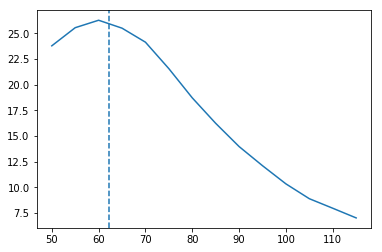

In [8]:
seed_range = [x for x in range(50, 120, 5)]
df = datasets['5aa5405e-4574-4dc1-be50-b31e5bafc4cb'].train
res = optimize_user(df, seed_range=seed_range)
res['test_vals'].plot().axvline(x=res['optimal'], linestyle='--')

## Optimize All Users

In [ ]:
seed_range = [x for x in range(50, 120, 5)]
test_vals = {}
optimals = {}
users_by_count = data.get_users()
for i in tqdm_notebook(range(len(users_by_count)), desc='Users'):
    user = users_by_count[i]
    res =  optimize_user(datasets[user].train, seed_range=seed_range)
    test_vals[user] = res['test_vals']
    optimals[user] = res['optimal']

In [8]:
test_vals = pd.read_csv('interval_threshold_test_vals.csv').set_index('Unnamed: 0')
optimals = pd.read_csv('interval_threshold_optimals.csv', header=None).set_index(0)[1].to_dict()

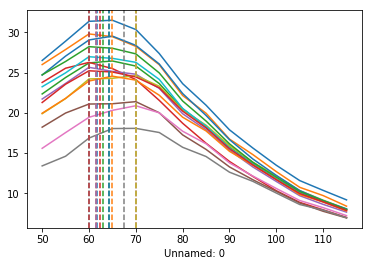

In [9]:
plt = pd.DataFrame(test_vals).plot()
for o in optimals:
    c = next(x._color for x in plt.legend().legendHandles if x._label == o)
    plt.axvline(x=optimals[o], color=c, linestyle='--')
plt.legend_.remove()

# Building Profile Using Threshold

In [28]:
class Node(object):
    def __init__(self, name):
        self.name = name
        self.children = {}
        self.stats = None
        self.parent = None
    def add(self, hash1):
        self.children[hash1.name] = hash1
        self.parent = self
        return hash1
    def goto(self, name):
        if(name in self.children):
            return self.children[name]

class Profile(object):
    def __init__(self, df, threshold, trim=None):
        self.trimmed = trim
        self.threshold = threshold
        if data is not None and threshold is not None:
            self._build_profile(df, threshold)
            if trim:
                self.profile = self.profile.loc[self.profile['count'] >= trim]
                self._build_tree()
            
    def _build_profile(self, df, t):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        start = -1
        seqs = []
        for row in df.itertuples():
            if start == -1:
                start = row.down
            chain.append(str(row.key))
            if row.interval > t:
                if len(chain) > 1:
                    seqs.append({'seq': '-'.join(chain), 'duration': np.log(row.up - start)})
                chain = []
                start = -1
        # Aggregate sequences
        seq_dur = pd.DataFrame(seqs).groupby('seq').aggregate(['mean', 'std', 'count']).duration
        # Fill missing values with a proxy
        seq_dur['std'] = seq_dur['std'].fillna((seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean'])
        self.profile = seq_dur
        self._build_tree()
        
    def _build_tree(self):
        self.root = Node('root')
        for s, row in self.profile.iterrows():
            n = self.root
            for k in s.split('-'):
                new = n.goto(k)
                if not new:
                    new = n.add(Node(k))
                n = new
            n.stats = row.to_dict()
            
    def trim(self, n):
        "Returns a new profile, trimmed to sequences with n instances"
        new_p = Profile(None, self.threshold, n)
        new_p.profile = self.profile.loc[self.profile['count'] >= n]
        new_p._build_tree()
        return new_p
    
    def search_tree(self, path):
        "Search tree for the node at a given list path"
        n = self.root
        for p in path:
            new = n.goto(p)
            if not new:
                return None
            n = new
        return n
    
    def features(self):
        return np.array(self.profile.index)

    def test_distance(self, path, duration):
        "Returns the probability that a typed path's duration was the profiles's"
        node = self.search_tree(path)
        if node is None or node.stats is None:
            return -1
        stats = node.stats
        return np.exp(-np.square((np.log(duration)-stats['mean']))/(2*np.square(stats['std'])))
    
    def test_window(self, df):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        start = -1
        instances = {}
        results = {}
        for f in self.features():
            instances[f] = []
            results[f] = 0
        for row in df.itertuples():
            if start == -1:
                start = row.down
            chain.append(str(row.key))
            seq = '-'.join(chain)
            if len(chain) > 1 and seq in instances:
                instances[seq].append(self.test_distance(chain, row.up - start))
            if row.interval > self.threshold:
                chain = []
                start = -1
        for f in instances:
            durations = instances[f]
            if len(durations) > 0:
                results[f] = np.mean(durations)
        return pd.Series(results)

In [23]:
userid_valid = data.get_users()[0]
train = datasets[userid_valid].train
test = datasets[userid_valid].test

train_valid = train.loc[train.is_user]
train_imposter = train.loc[train.is_user == False]

test_valid = test.loc[test.is_user]
test_imposter = test.loc[test.is_user == False]

# user_threshold = optimals[userid_valid]
user_threshold = 90

In [29]:
p = Profile(train_valid, user_threshold, trim=20)

In [34]:
result = p.test_window(test_valid)
result.loc[result == 0] = np.nan
np.nanmean(result)

0.7145667262557678

In [14]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    front = []
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [15]:
def split_windows(df, window_size):
    X = []
    Y = []
    for i in tnrange(df.is_user.count()):
        series = df.loc[i-window_size:i]
        X.append(np.array(p.test_window(series)))
        Y.append(series.is_user.iloc[-1])
    return np.array(X), np.array(Y).astype('int16')

In [16]:
def split_window(df, window_size, i):
    series = df.loc[i-window_size:i]
    return np.array(p.test_window(series))

In [17]:
def split_windows(df, window_size):
    arr = [df.loc[i-window_size:i] for i in tnrange(df.is_user.count())]
    X = parallel_process(arr, p.test_window, front_num=0)
    Y = df.is_user.astype('int16')
    return np.array(X), np.array(Y).reshape(Y.count(),1)

In [18]:
seq_length = 50

In [19]:
x_train, y_train = split_windows(train.head(100000), seq_length)
x_test, y_test = split_windows(test.head(100000), seq_length)

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

100%|██████████| 100k/100k [04:56<00:00, 337it/s]   
100000it [00:00, 413836.16it/s]


HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

100%|██████████| 100k/100k [04:42<00:00, 354it/s]   
100000it [00:00, 415591.99it/s]


# Build LSTM Model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [21]:
# Network Parameters
num_samples = x_train.shape[0]
input_features = x_train.shape[1]
n_hidden_1 = input_features*2 # 1st layer number of features
n_classes = 1 # Number of classes to predict
batch_size = 60

In [22]:
# create model
lstm_model = Sequential()
# add layers
lstm_model.add(LSTM(n_hidden_1, input_shape=(seq_length, input_features), implementation=2))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(n_classes, activation='sigmoid'))
# compile model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
def data_gen(x, y, seq_length, batch_size=32):
    """
    Generator to yield inputs and their labels in batches.
    """
    i = 0
    while True:
        batch_x = []
        batch_y = []
        i = i % 90000
        for j in range(batch_size):
            # Set a label
            off = i+j
            batch_x.append(x[off:seq_length+off])
            batch_y.append(y[off])
        i = i + batch_size
        yield np.array(batch_x), np.array(batch_y)

In [24]:
filepath="./gaussian-lstm-models/weights-improvement-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph/Gaussian_LSTM/', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

In [ ]:
!rm -R ./Graph/Gaussian_LSTM/*
!rm ./gaussian-lstm-models/*

rm: cannot remove './gaussian-lstm-models/*': No such file or directory


In [ ]:
lstm_model.fit_generator(data_gen(x_train, y_train, seq_length, batch_size), epochs=20, steps_per_epoch=10000, callbacks=callbacks_list)

Epoch 1/20
 2770/10000 [=======>......................] - ETA: 26:16 - loss: 0.5906 - acc: 0.7271

## Test It

In [82]:
def far(y_true, y_pred, thresh=0.5):
    total_false = np.equal(y_true, 0).astype('int32').sum()
    false_accepts = (np.equal(y_true, 0) & np.greater_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_accepts/total_false

def frr(y_true, y_pred, thresh=0.5):
    total_accept = np.equal(y_true, 1).astype('int32').sum()
    false_rejects = (np.equal(y_true, 1) & np.less_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_rejects/total_accept

In [23]:
lstm_model.load_weights('./gaussian-lstm-models/weights-improvement-21-0.98.hdf5')

In [111]:
def evaluate(x_data, y_data, model_path='./gaussian-lstm-models/weights-improvement-25-0.98.hdf5', index=0, plot=True):
    lstm_model.load_weights(model_path)
    x, y = next(data_gen(x_data, y_data, seq_length, 50000))
    y_pred = lstm_model.predict(x)

    fpr, tpr, thresholds = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    plt.plot(fpr,tpr,label="LSTM"+str(index)+", auc="+str(auc))

    false_accepts = far(y.flatten(), y_pred.flatten())
    false_rejects = frr(y.flatten(), y_pred.flatten())
    accuracy = metrics.accuracy_score(y.flatten(), np.round(y_pred.flatten()))
    print('Model: %s (FAR: %4f FRR: %4f ACC: %4f)' % (model_path, false_accepts, false_rejects, accuracy))
    
    if plot:
        plt.legend(loc=4)
        plt.show()

def evaluate_many(x_data, y_data, model_paths):
    index = 0
    for m in model_paths:
        evaluate(x_data, y_data, m, index=index, plot=False)
        index = index + 1
    plt.legend(loc=4)
    plt.show()

Model: ./gaussian-lstm-models/weights-improvement-25-0.98.hdf5 (FAR: 0.203950 FRR: 0.104623 ACC: 0.861880)
Model: ./gaussian-lstm-models/weights-improvement-21-0.98.hdf5 (FAR: 0.240541 FRR: 0.094393 ACC: 0.856320)
Model: ./gaussian-lstm-models/weights-improvement-20-0.98.hdf5 (FAR: 0.244989 FRR: 0.092492 ACC: 0.856080)
Model: ./gaussian-lstm-models/weights-improvement-18-0.98.hdf5 (FAR: 0.244692 FRR: 0.093307 ACC: 0.855640)
Model: ./gaussian-lstm-models/weights-improvement-17-0.98.hdf5 (FAR: 0.198968 FRR: 0.106434 ACC: 0.862360)
Model: ./gaussian-lstm-models/weights-improvement-15-0.98.hdf5 (FAR: 0.267406 FRR: 0.090832 ACC: 0.849620)


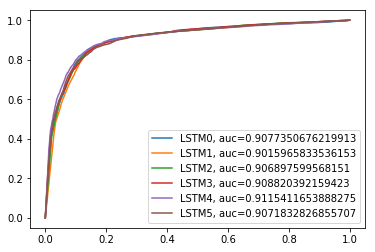

In [113]:
evaluate_many(x_test, y_test, [
    './gaussian-lstm-models/weights-improvement-25-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-21-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-20-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-18-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-17-0.98.hdf5',
    './gaussian-lstm-models/weights-improvement-15-0.98.hdf5'
])s

Model: ./gaussian-lstm-models/weights-improvement-20-0.98.hdf5 (FAR: 0.244989 FRR: 0.092492 ACC: 0.856080)
Model: ./gaussian-lstm-models/weights-improvement-03-0.94.hdf5 (FAR: 0.451844 FRR: 0.054409 ACC: 0.811560)
Model: ./gaussian-lstm-models/weights-improvement-05-0.96.hdf5 (FAR: 0.189183 FRR: 0.130062 ACC: 0.850000)
Model: ./gaussian-lstm-models/weights-improvement-21-0.98.hdf5 (FAR: 0.240541 FRR: 0.094393 ACC: 0.856320)
Model: ./gaussian-lstm-models/weights-improvement-09-0.97.hdf5 (FAR: 0.232001 FRR: 0.103356 ACC: 0.853260)
Model: ./gaussian-lstm-models/weights-improvement-18-0.98.hdf5 (FAR: 0.244692 FRR: 0.093307 ACC: 0.855640)
Model: ./gaussian-lstm-models/weights-improvement-25-0.98.hdf5 (FAR: 0.203950 FRR: 0.104623 ACC: 0.861880)
Model: ./gaussian-lstm-models/weights-improvement-01-0.81.hdf5 (FAR: 0.436900 FRR: 0.049369 ACC: 0.819940)
Model: ./gaussian-lstm-models/weights-improvement-13-0.98.hdf5 (FAR: 0.213616 FRR: 0.110719 ACC: 0.854580)
Model: ./gaussian-lstm-models/weights

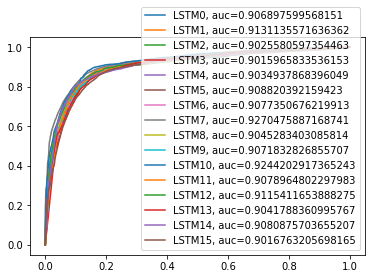

In [117]:
import glob
import os

evaluate_many(x_test, y_test,[f for f in glob.glob(os.path.join('./gaussian-lstm-models/', '*.hdf5'))])

In [101]:
pd.DataFrame({'actual': y.flatten(), 'predicted': y_pred.flatten()}).to_csv('acutal_predicted_output.csv')